In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import time
plt.rcParams['savefig.dpi'] = 128

In [2]:
from bayes_classifier import *
from image_manipulation import *
from maximum_likelihood import *

In [3]:
TRAINING_SET = 1 # Set to either 1, 3, or 6
TESTING_SET = 3 # Set to either 1, 3, or 6

In [4]:
TRAINING_FILE = 'data_3/Training_{n}.ppm'.format(n=TRAINING_SET)
TRAINING_MASK = 'data_3/ref{n}.ppm'.format(n=TRAINING_SET)
TESTING_FILE = 'data_3/Training_{n}.ppm'.format(n=TESTING_SET)
TESTING_MASK = 'data_3/ref{n}.ppm'.format(n=TESTING_SET)

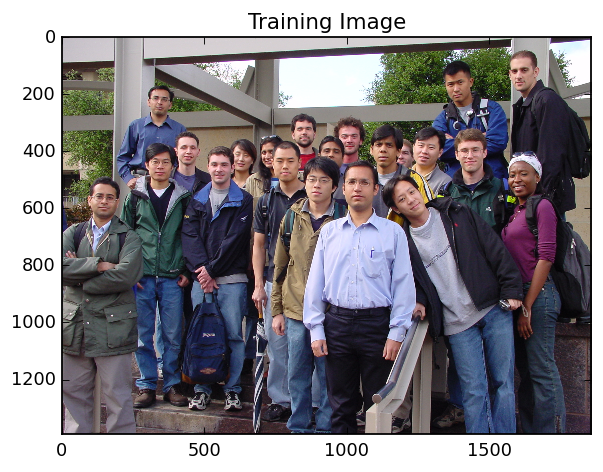

In [5]:
# Load training image
img = readImg(TRAINING_FILE)
plt.imshow(img.astype('uint8'))
plt.title('Training Image')
plt.show()

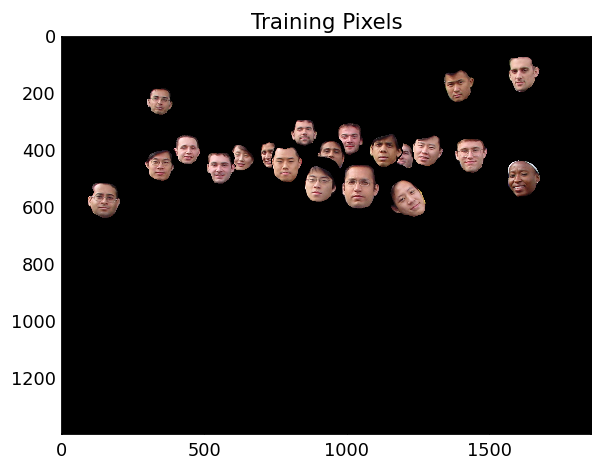

In [6]:
# Load mask
mask = rgbToGray(readImg(TRAINING_MASK))>0
plt.title('Training Pixels')
plt.imshow(img*mask[:, :, np.newaxis]/255.0)
plt.show()

C:\Users\Will\Documents\GitHub\Pattern-Recognition\Maximum-Likelihood\image_manipulation.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if mask == None:


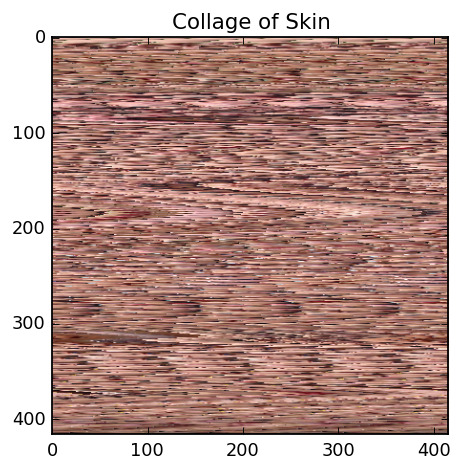

In [7]:
# Get pixels
training = getPixels(img, mask)
# Display
w = int(math.sqrt(training.shape[0]))
plt.title('Collage of Skin')
plt.imshow(training[:w**2].reshape((w, w, 3)).astype('uint8'))
plt.show()

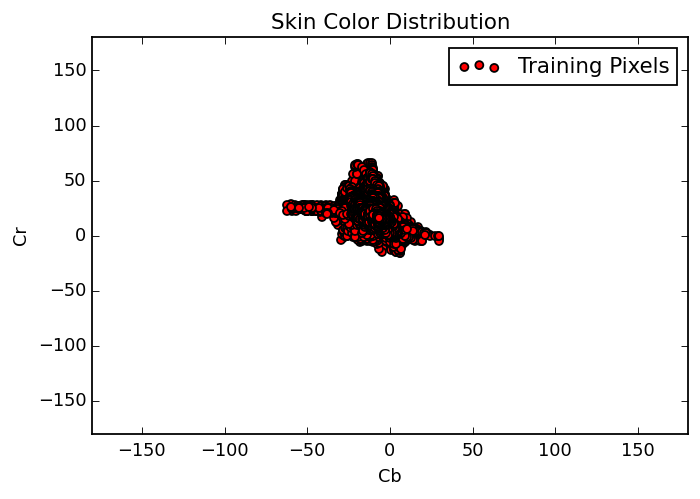

In [8]:
# Convert to YCbCr
training_CbCr = RGBPixelsToYCbCr(training)[:, 1:]
plt.title('Skin Color Distribution')
plt.xlabel('Cb'); plt.xlim([-180.0, 180.0])
plt.ylabel('Cr'); plt.ylim([-180.0, 180.0])
plt.scatter(training_CbCr[:, 0], training_CbCr[:, 1], c='r', label='Training Pixels')
plt.legend()
plt.show()

In [9]:
# Get the distribution
dist = getMaximumLikelihood(training_CbCr)
print(dist)

mu=[-12.69134026  23.63426875], covar=[[ 31.19704223   0.        ]
 [  0.          48.94555422]], prior=1.0


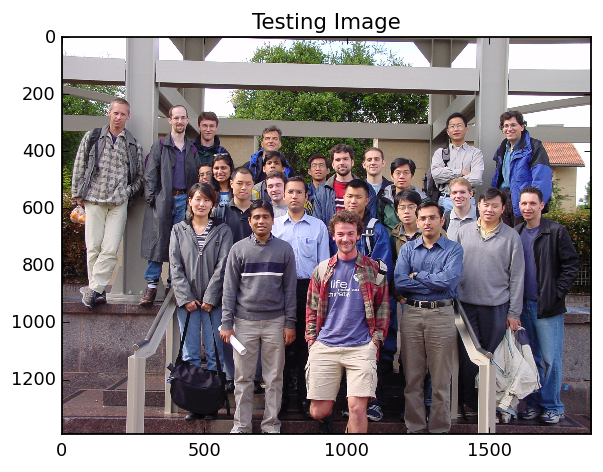

In [10]:
# Load test image
test_rgb = readImg(TESTING_FILE)
test_mask = rgbToGray(readImg(TESTING_MASK))>0
plt.imshow(test_rgb.astype('uint8'))
plt.title('Testing Image')
plt.show()

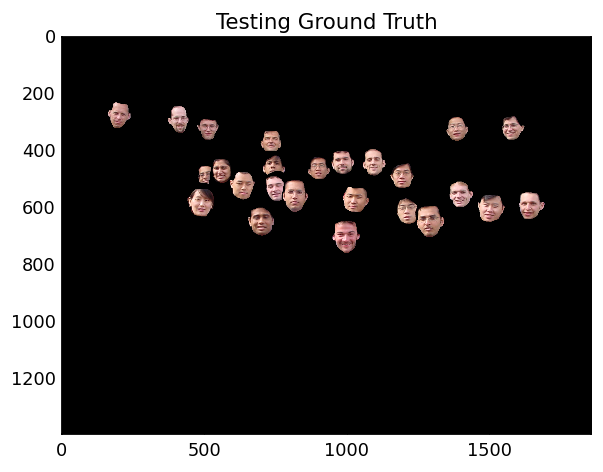

In [11]:
# Show testing pixels
plt.title('Testing Ground Truth')
plt.imshow((test_rgb*test_mask[:, :, np.newaxis]).astype('uint8'))
plt.show()

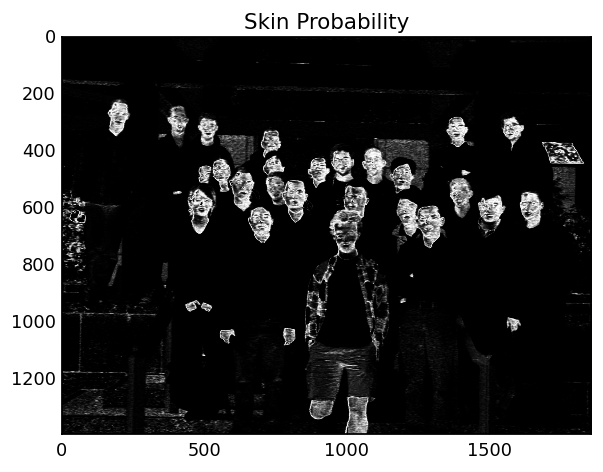

In [12]:
# Load
h, w = test_rgb.shape[0], test_rgb.shape[1]
test_rgb = getPixels(test_rgb, None)
test_cbcr = RGBPixelsToYCbCr(test_rgb)[:, 1:]
test_mask = test_mask.reshape(np.prod(test_mask.shape))
# Get probability
logProbs = dist.getLogProbs(test_cbcr)
probs = np.exp(logProbs)
# Plot
plt.title('Skin Probability')
plt.imshow(probs.reshape((h, w))/probs.max(), cmap='gray')
plt.show()

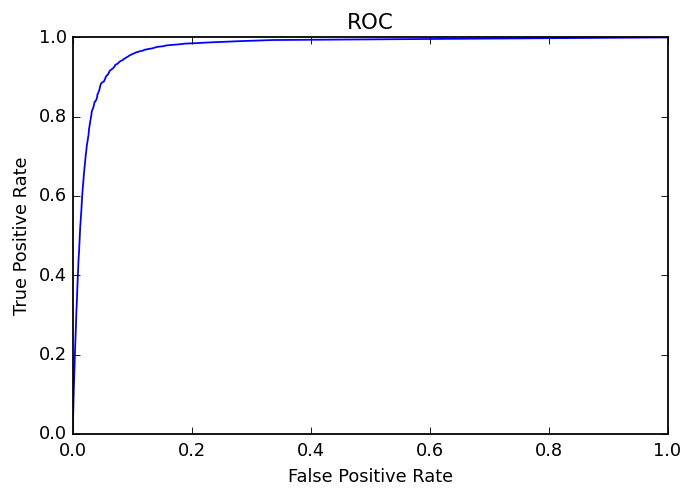

In [13]:
resolution = 500
thresholds = np.linspace(0.0, probs.max(), resolution)

# Test
tot = float(len(test_mask))
totSkin = float(test_mask.sum())
totNonSkin = tot-totSkin
tpr = []
fpr = []
err = []
trueSkin = test_mask
trueNonSkin = ~test_mask
for thresh in thresholds:
    skin = (probs>=thresh)
    nonSkin = ~skin
    #
    tp = (skin & trueSkin).sum() / totSkin
    fp = (skin & trueNonSkin).sum() / totNonSkin
    e = ( (skin & trueNonSkin) | (nonSkin & trueSkin) ).sum()/tot
    err.append(e)
    tpr.append(tp)
    fpr.append(fp)
# Plot
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(fpr, tpr)
plt.show()

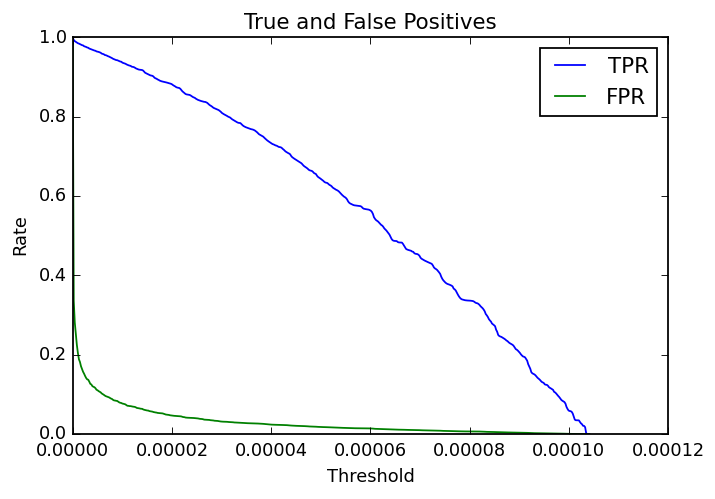

In [14]:
plt.title('True and False Positives')
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.plot(thresholds, tpr, label='TPR')
plt.plot(thresholds, fpr, label='FPR')
plt.legend()
plt.show()

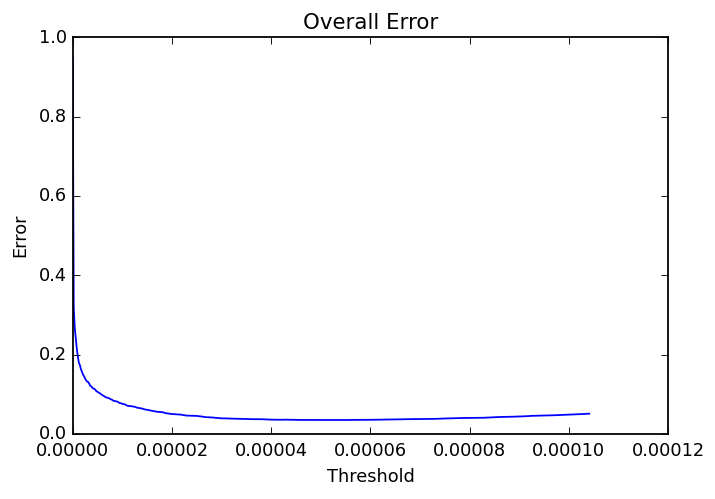

In [15]:
plt.title('Overall Error')
plt.xlabel('Threshold')
plt.ylabel('Error')
plt.plot(thresholds, err)
plt.show()

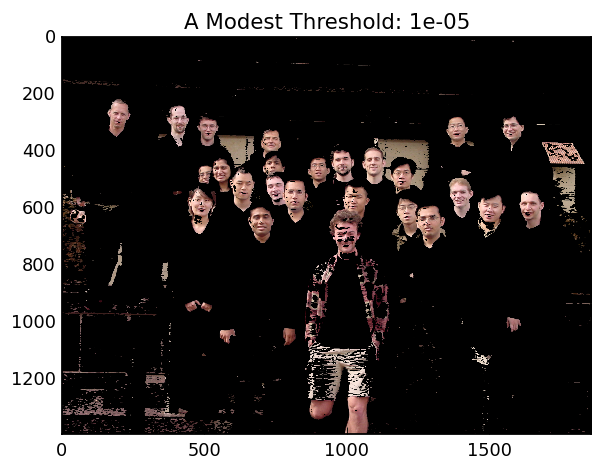

In [16]:
thresh = 1E-5
skin = probs>=thresh
plt.title('A Modest Threshold: {t}'.format(t=thresh))
plt.imshow((test_rgb * skin[:, np.newaxis]).reshape(h, w, 3).astype('uint8'))
plt.show()